In [1]:
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt

max_word_len = 20
start_token = '\t'
end_token = '\n'

In [13]:
def is_valid(word):
    return re.match('[A-Z]*(\(\d+\))?$', word) and len(word) <= max_word_len

def process(word):
    match = re.search('[A-Z]*', word)
    return match.group()

def remove_last(word):
    return re.sub('(\(\d+\))?$', '', word)

In [18]:
# data in dict format
data_dict = {} # keys are words and values are lists of pronunciation as strings

words_all = set() # for counting the total number of words

# data in list format
data_chars = [] # each element in the list is a list of characters (representing a word)
data_phonemes = [] # each element in the list is a list of phonemes (representing a pronunciation)

# these will contain all unique characters/phonemes from the dataset
list_characters = set()
list_phonemes = set()

rejected = set()

filename_data = 'cmudict.txt'

with open(filename_data, encoding='ISO-8859-1') as data_file:
    
    total_pronunciations = 0
    kept_pronunciations = 0
    
    for line in data_file:
    
        # skip comments
        if line[:3] == ';;;':
            continue
        
        # split line into word and phonemes
        word, phonemes = line.strip().split('  ')
        
        total_pronunciations += 1
        
        if remove_last(word) not in words_all:
            words_all.add(remove_last(word))
        
        # check if word is valid
        if is_valid(word):
            
            kept_pronunciations += 1
            
            # remove (#) ending for words with multiple pronounciations
            clean_word = process(word)
            
            # add new word to dict
            if clean_word not in data_dict:
                data_dict[clean_word] = []
            
            # add pronunciation to dict
            data_dict[clean_word].append(phonemes)
            
            # convert phoneme string to list and append special 'start' and 'end' symbols
            phonemes = [start_token] + phonemes.split(' ') + [end_token]
            
            # add list of characters and list of phonemes to lists
            data_chars.append(list(clean_word))
            data_phonemes.append(phonemes)
            
            # update list of all characters
            for c in clean_word:
                list_characters.add(c)
            
            # update list of all phonemes
            for p in phonemes:
                list_phonemes.add(p)
                    
list_characters = sorted(list(list_characters))
list_phonemes = sorted(list(list_phonemes))

num_samples = len(data_chars)

num_encoder_tokens = len(list_characters)
num_decoder_tokens = len(list_phonemes)

max_encoder_seq_len = max([len(seq) for seq in data_chars])
max_decoder_seq_len = max([len(seq) for seq in data_phonemes])

print('Number of words before preprocessing:', len(list(words_all)))
print('Number of pronunciations before preprocessing:', total_pronunciations)
print('Number of words after preprocessing:', len(list(data_dict.values())))
print('Number of pronunciations after preprocessing:', kept_pronunciations)
print()

print('Number of samples:', num_samples)
print('Number of unique characters:', num_encoder_tokens)
print('Number of unique phonemes:', num_decoder_tokens)
print('Max sequence length for words:', max_encoder_seq_len)
print('Max sequence length for pronunciations:', max_decoder_seq_len)


Number of words before preprocessing: 125074
Number of pronunciations before preprocessing: 133854
Number of words after preprocessing: 116503
Number of pronunciations after preprocessing: 124558

Number of samples: 124558
Number of unique input tokens (characters): 26
Number of unique output tokens (phonemes): 71
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [18]:
# save dict
with open('data_dict.pickle', 'wb') as file_out:
    pickle.dump(data_dict, file_out)

In [6]:
# create mappings
def create_maps(elements):
    return {e:i for i,e in enumerate(elements)}, {i:e for i,e in enumerate(elements)}

map_char_id, map_id_char = create_maps(list_characters)
map_phoneme_id, map_id_phoneme = create_maps(list_phonemes)

# print(map_char_id)
# print(map_id_char)
# print(map_phoneme_id)

In [14]:
# save mappings
with open('mappings.pickle', 'wb') as file_out:
    pickle.dump({'char_id':map_char_id, 'id_char':map_id_char,
                 'phoneme_id':map_phoneme_id, 'id_phoneme':map_id_phoneme},
                file_out)

In [7]:
# convert character and phoneme data to 3D arrays
encoder_input_data = np.zeros(
    (num_samples, max_encoder_seq_len, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (num_samples, max_decoder_seq_len, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (num_samples, max_decoder_seq_len, num_decoder_tokens),
    dtype='float32')

for i_sample, (chars, phonemes) in enumerate(zip(data_chars, data_phonemes)):
    for i_char, char in enumerate(chars):
        encoder_input_data[i_sample, i_char, map_char_id[char]] = 1.
    for i_phoneme, phoneme in enumerate(phonemes):
        decoder_input_data[i_sample, i_phoneme, map_phoneme_id[phoneme]] = 1.

print(encoder_input_data.shape)
print(decoder_input_data.shape)

# print(decoder_target_data[0][0])

(124558, 20, 26)
(124558, 21, 71)


In [13]:
# save 3D arrays
with open('data_preprocessed.pickle', 'wb') as file_out:
    pickle.dump({'chars':encoder_input_data, 'phonemes':decoder_input_data}, file_out)

ANTIDISESTABLISHMENTARIANISM
DEINSTITUTIONALIZATION
SUPERCALIFRAGILISTICEXPIALIDOCIOUS
{0: 1, 1: 26, 2: 200, 3: 1529, 6: 21357, 8: 17756, 5: 14556, 7: 22120, 9: 13015, 4: 6533, 10: 8727, 11: 5071, 12: 2893, 13: 1555, 14: 691, 15: 348, 16: 140, 17: 64, 18: 21, 28: 1, 19: 6, 20: 6, 22: 1, 34: 1}


<BarContainer object of 24 artists>

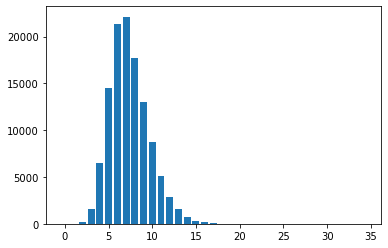

In [18]:
word_len_freq = {}

for word in all_words:
    length = len(word)
    
    if length > 20:
        print(word)
    
    if length not in word_len_freq:
        word_len_freq[length] = 0
    word_len_freq[length] += 1
    
print(word_len_freq)
    
fig, ax = plt.subplots()
ax.bar(list(word_len_freq.keys()), list(word_len_freq.values()))